## **1. Importation des Bibliothèques**

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,learning_curve,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV


## **2. Chargement des Données**

In [77]:
# Charger le fichier CSV
earthquake_data = pd.read_csv('earthquakes.csv')


# Affichage du dimensions des données
print(f"\nDimensions des données : {earthquake_data.shape}")

# Liste des colonnes
print("\nListe des colonnes :")
print(earthquake_data.columns)

# Résumé des données
print("\nRésumé des données :")
print(earthquake_data.info())




Dimensions des données : (1137, 43)

Liste des colonnes :
Index(['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url',
       'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place',
       'distanceKM', 'placeOnly', 'location', 'continent', 'country',
       'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone',
       'locationDetails'],
      dtype='object')

Résumé des données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1137 non-null   object 
 1   magnitude        1137 non-null   float64
 2   type             1137 non-null   object 
 3   title            1137 non-null   object 
 4   date             1137

## **3. Prétraitement des Données**

### **3.1 Suppression des colonnes inutiles**

In [78]:
# Colonnes à supprimer
columns_to_drop = [
    # Identifiants et liens
    'id', 'url', 'detailUrl','ids' ,

    # Colonnes descriptifs
    'title', 'updated','status','code','sources','types',

    # Informations inutilisables
    'what3words', 'locationDetails', 'location','subnational','place', 'placeOnly','locality','tsunami','continent', 'country',

    # Colonnes temporelles brutes
    'date', 'time','timezone',

    # Colonnes constantes
    'type', 'geometryType'
]

# Suppression des colonnes
earthquake_data_cleaned = earthquake_data.drop(columns=columns_to_drop)

# Vérification après suppression
print("Colonnes supprimées avec succès.")
print(f"Dimensions après suppression : {earthquake_data_cleaned.shape}")
print("Liste des colonnes restantes :")
print(earthquake_data_cleaned.columns)


Colonnes supprimées avec succès.
Dimensions après suppression : (1137, 18)
Liste des colonnes restantes :
Index(['magnitude', 'felt', 'cdi', 'mmi', 'alert', 'sig', 'net', 'nst', 'dmin',
       'rms', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'distanceKM',
       'city', 'postcode'],
      dtype='object')


### **3.2 Gestion des valeurs manquantes**

In [79]:
#Detecte les valeurs manquantes
missing_values=earthquake_data_cleaned.isna().sum()
missing_values[missing_values > 0]

,0
alert,373
city,463
postcode,940


In [80]:
# Supprimer les lignes où la cible est manquante
data = earthquake_data_cleaned.dropna(subset=['alert'])

# Calculer les valeurs manquantes et leur pourcentage
missing_values = data.isna().sum()
missing_percentage = (missing_values / data.shape[0]) * 100

# Filtrer pour ne garder que les colonnes ayant des valeurs manquantes
missing_summary = pd.DataFrame({
    'Valeurs Manquantes': missing_values,
    'Pourcentage (%)': [f"{p:.2f}%" for p in missing_percentage]
})
missing_summary = missing_summary[missing_summary['Valeurs Manquantes'] > 0]

# Afficher le résultat
print(missing_summary)


          Valeurs Manquantes Pourcentage (%)
city                     392          51.31%
postcode                 696          91.10%


In [81]:
# Supprimer les colonnes qui contient plus de 50% des valeurs manquantes
data = data.drop(columns=['postcode','city'])

### **3.3 Gestion des valeurs aberrantes (Outliers)**



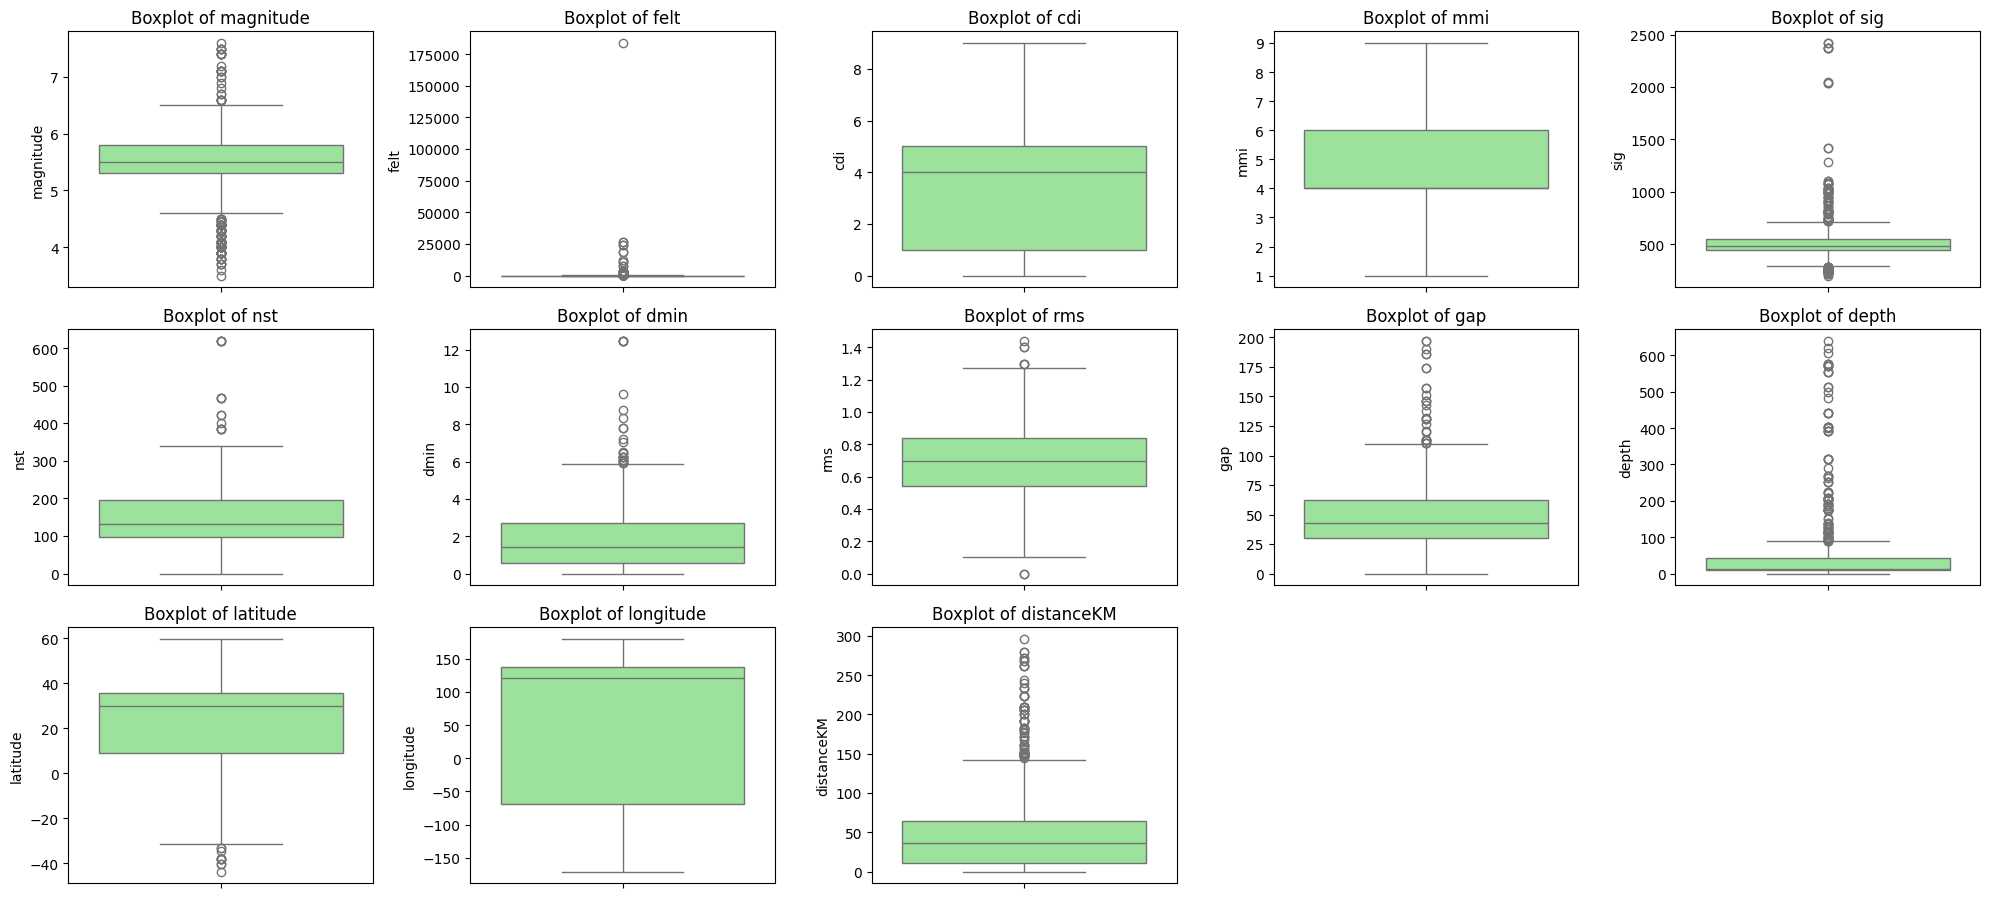

In [82]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(20, 15))

# Créer des subplots pour chaque colonne
for i, col in enumerate(numeric_columns):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=data[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

In [83]:
# Fonction pour remplacer les outliers par la médiane
def replace_outliers_with_median(df, numeric_columns, threshold=1.5):
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)  # Premier quartile
        Q3 = df[col].quantile(0.75)  # Troisième quartile
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Calculer le nombre d'outliers avant remplacement
        outliers_before = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers_before = len(outliers_before)

        # Remplacer les outliers par la médiane
        median_value = df[col].median()
        df[col] = df[col].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

        # Calculer le nombre d'outliers après remplacement
        outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers_after = len(outliers_after)

        # Afficher les résultats
        print(f"Colonne '{col}':")
        print(f"  - {num_outliers_before} outliers détectés avant remplacement.")
        print(f"  - {num_outliers_after} outliers restants après remplacement.\n")
    print(f"Taille du DataFrame après remplacement des outliers : {df.shape}\n")
    return df

# Appliquer la fonction
data_cleaned = replace_outliers_with_median(data.copy(), numeric_columns, threshold=1.5)


Colonne 'magnitude':
  - 122 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'felt':
  - 123 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'cdi':
  - 0 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'mmi':
  - 0 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'sig':
  - 125 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'nst':
  - 14 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'dmin':
  - 24 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'rms':
  - 8 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'gap':
  - 30 outliers détectés avant remplacement.
  - 0 outliers restants après remplacement.

Colonne 'depth':
  - 107 outliers détectés avan

### **3.4 Équilibrage de dataset avec methode SMOTE**

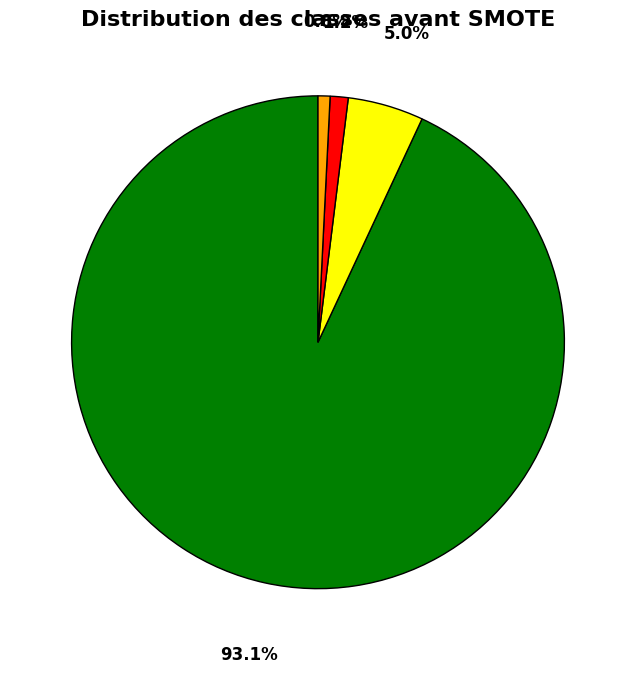

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


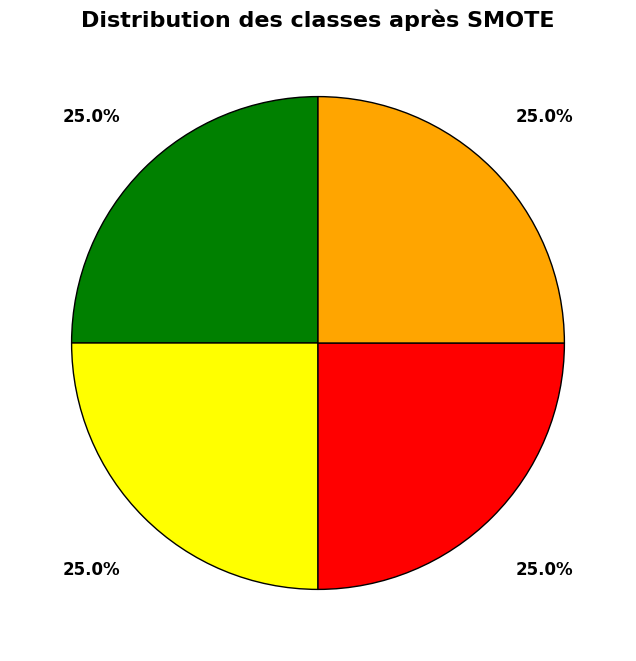

Taille des données équilibrées : (2844, 16)


In [137]:

# Dictionnaire des couleurs pour chaque classe
class_colors = {
    0: 'green',    # Classe 0 - Vert
    1: 'yellow',   # Classe 1 - Jaune
    2: 'orange',   # Classe 2 - Orange
    3: 'red'       # Classe 3 - Rouge
}

# Fonction pour afficher un camembert avec étiquettes ajustées
def plot_pie_with_labels(data, class_colors, title):
    plt.figure(figsize=(8, 8))

    # Création du camembert
    wedges, texts, autotexts = plt.pie(
        data,
        autopct=lambda pct: ('%.1f%%' % pct) if pct > 0 else '',  # Affiche uniquement les pourcentages > 0
        startangle=90,
        colors=[class_colors[cls] for cls in data.index],
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'black'}
    )

    # Ajustement des étiquettes pour les petites classes
    for i, autotext in enumerate(autotexts):
        if autotext.get_text():
            angle = (wedges[i].theta2 + wedges[i].theta1) / 2
            x = np.cos(np.radians(angle))
            y = np.sin(np.radians(angle))
            autotext.set_position((1.3 * x, 1.3 * y))
            autotext.set_fontsize(12)
            autotext.set_weight('bold')

    plt.title(title, fontsize=16, weight='bold')
    plt.ylabel('')
    plt.show()

#Visualiser la distribution des classes avant SMOTE
data = y.value_counts()
plot_pie_with_labels(data, class_colors, "Distribution des classes avant SMOTE")

# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)


# Visualiser la distribution des classes après SMOTE
balanced_data = y_balanced.value_counts()
plot_pie_with_labels(balanced_data, class_colors, "Distribution des classes après SMOTE")

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.4, random_state=42, stratify=y_balanced
)

# (Optionnel) Créer le DataFrame final des données équilibrées
balanced_data_df = pd.concat(
    [pd.DataFrame(X_balanced, columns=X.columns), pd.DataFrame(y_balanced, columns=['alert'])],
    axis=1
)

print("Taille des données équilibrées :", balanced_data_df.shape)

## **4. Feature Engineering**

### **4.1 Encodage des Variables categorials  :**

In [84]:
# Définir l'ordre des catégories
alert_categories = [['green', 'yellow', 'orange', 'red']]

# Appliquer l'encodage ordinal
encoder = OrdinalEncoder(categories=alert_categories)
data_cleaned['alert'] = encoder.fit_transform(data_cleaned[['alert']])
data_cleaned['alert']

,alert
0,0.0
1,0.0
3,0.0
4,0.0
8,0.0
...,...
1132,2.0
1133,1.0
1134,2.0
1135,0.0


In [85]:
# Définir l'ordre des catégories
categories = [['mww', 'ml', 'mb', 'mw', 'mwr', 'mb_lg', 'mwb', 'mi']]

# Appliquer l'encodage ordinal
encoder = OrdinalEncoder(categories=categories)
data_cleaned['magType'] = encoder.fit_transform(data_cleaned[['magType']])
data_cleaned['magType']


,magType
0,0.0
1,1.0
3,1.0
4,2.0
8,3.0
...,...
1132,0.0
1133,2.0
1134,0.0
1135,0.0


In [86]:
# Définir l'ordre des catégories
categories = [['ak', 'at', 'ci', 'nc', 'nn', 'nm', 'ok', 'tx', 'us', 'uu', 'uw']]

# Appliquer l'encodage ordinal
encoder = OrdinalEncoder(categories=categories)
data_cleaned['net'] = encoder.fit_transform(data_cleaned[['net']])
data_cleaned['net']

,net
0,8.0
1,7.0
3,7.0
4,8.0
8,2.0
...,...
1132,8.0
1133,8.0
1134,8.0
1135,8.0


### **4.2 Calculer et afficher la matrice de corrélation :**

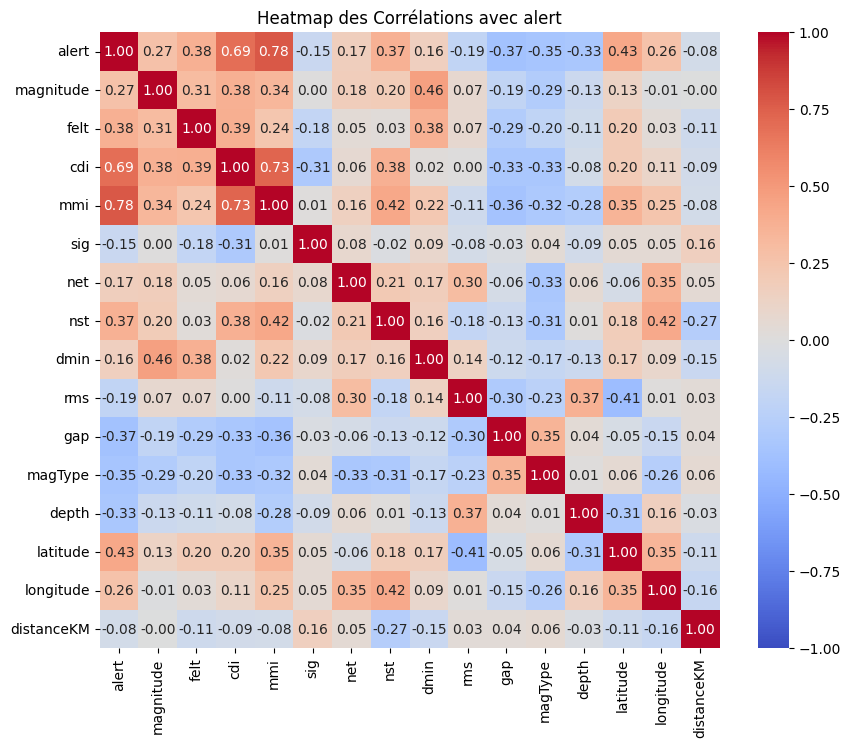

In [88]:
# Calculer la matrice de corrélation
correlation_matrix = balanced_data.corr()

# Réorganiser la matrice pour mettre 'alert' en première colonne et première ligne
columns_order = ['alert'] + [col for col in correlation_matrix.columns if col != 'alert']
correlation_matrix = correlation_matrix.loc[columns_order, columns_order]

# Création de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Heatmap des Corrélations avec alert')
plt.show()


### **4.3 Nettoyage et Transformation des Données après Analyse de Corrélation**

In [89]:
#La fusion des colonnes 'mmi' et 'cdi' pour créer une nouvelle colonne moyenne:
if 'mmi' in balanced_data.columns and 'cdi' in balanced_data.columns:
    # Fusionner 'mmi' et 'cdi' en une seule colonne
    balanced_data['mmi_cdi_avg'] = balanced_data[['mmi', 'cdi']].mean(axis=1)

    # Supprimer les colonnes originales
    balanced_data.drop(columns=['mmi', 'cdi'], inplace=True)
else:
    print("Les colonnes 'mmi' et/ou 'cdi' n'existent pas dans le DataFrame.")

#La suppression des colonnes jugées inutiles ('sig', 'rms', 'net', 'dmin', et 'distanceKM'):
columns_to_remove = ['sig', 'rms', 'net','dmin','distanceKM']
existing_columns = [col for col in columns_to_remove if col in balanced_data.columns]

if existing_columns:
    balanced_data.drop(columns=existing_columns, inplace=True)
    print(f"Colonnes supprimées : {existing_columns}")
else:
    print("Aucune des colonnes 'sig', 'rms', 'net','dmin','distanceKM' n'existe dans le DataFrame.")


Colonnes supprimées : ['sig', 'rms', 'net', 'dmin', 'distanceKM']


In [90]:
# Vérification
print(f"Colonnes restantes : {balanced_data.columns.tolist()}")

Colonnes restantes : ['magnitude', 'felt', 'nst', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'alert', 'mmi_cdi_avg']


## **5. Entraînement des modèles**

### **5.1 Entraîment du modèle RandomForest**

In [152]:
# Initialisation du classifieur RandomForest
rf_classifier = RandomForestClassifier(
    n_estimators=100,           # Nombre d'arbres dans la forêt
    max_depth=4,               # Profondeur maximale des arbres
    min_samples_split=10,      # Nombre minimal d'échantillons pour diviser un noeud
    min_samples_leaf=5,        # Nombre minimal d'échantillons dans une feuille
    random_state=42            # Assure la reproductibilité
)

# Entraîment du modèle
rf_classifier.fit(X_train, y_train)

# Prédictions sur les ensembles d'entraînement et de test
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calcul des métriques d'évaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
mse_values ,mae_values = [],[]
mse_values.append(test_mse)
mae_values.append(test_mae)

# Affichage des résultats
print(f"Accuracy sur l'ensemble de test : {test_accuracy}")
print(f"MSE sur l'ensemble de test : {test_mse}")
print(f"MAE sur l'ensemble de test : {test_mae}")

Accuracy sur l'ensemble de test : 0.9824253075571178
MSE sur l'ensemble de test : 0.03866432337434095
MAE sur l'ensemble de test : 0.022847100175746926


### **5.2 Entraîment du modèle Gradient Boosting Classifier**

In [153]:
# Initialisation du modèle Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(
    learning_rate=0.001,         # Taux d'apprentissage
    max_depth=3,                 # Profondeur maximale
    min_samples_split=10,        # Minimum d'échantillons pour diviser un noeud
    min_samples_leaf=5,          # Minimum d'échantillons dans une feuille
    random_state=42              # Assure la reproductibilité
)

# Entraînement du modèle
gb_classifier.fit(X_train, y_train)

# Prédictions sur les ensembles d'entraînement et de test
y_train_pred = gb_classifier.predict(X_train)
y_test_pred = gb_classifier.predict(X_test)

# Calcul des métriques d'évaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
mse_values.append(test_mse)
mae_values.append(test_mae)

# Affichage des résultats
print(f"Accuracy sur l'ensemble de test : {test_accuracy}")
print(f"MSE sur l'ensemble de test : {test_mse}")
print(f"MAE sur l'ensemble de test : {test_mae}")

Accuracy sur l'ensemble de test : 0.9824253075571178
MSE sur l'ensemble de test : 0.02460456942003515
MAE sur l'ensemble de test : 0.019332161687170474


### **5.3 Entraîment du modèle CatBoostClassifier**

In [154]:
# Initialisation du modèle CatBoostClassifier
catboost_classifier = CatBoostClassifier(
    iterations=1000,           # Nombre d'itérations (arbres)
    learning_rate=0.001,       # Taux d'apprentissage
    depth=6,                   # Profondeur des arbres
    loss_function='MultiClass',# Supporte les problèmes multiclasse
    random_seed=42,            # Pour la reproductibilité
    verbose=100                # Affiche les logs chaque 100 itérations
)

# Entraînment du modèle
catboost_classifier.fit(X_train, y_train)

# Prédictions sur les ensembles d'entraînement et de test
y_train_pred = catboost_classifier.predict(X_train)
y_test_pred = catboost_classifier.predict(X_test)

# Calcul des métriques d'évaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
mse_values.append(test_mse)
mae_values.append(test_mae)

# Affichage des résultats
print(f"Accuracy sur l'ensemble de test : {test_accuracy}")
print(f"MSE sur l'ensemble de test : {test_mse}")
print(f"MAE sur l'ensemble de test : {test_mae}")

0:	learn: 1.3838433	total: 14.2ms	remaining: 14.2s
100:	learn: 1.1869487	total: 995ms	remaining: 8.86s
200:	learn: 1.0336091	total: 1.96s	remaining: 7.78s
300:	learn: 0.9099940	total: 2.94s	remaining: 6.82s
400:	learn: 0.8081168	total: 3.9s	remaining: 5.83s
500:	learn: 0.7230260	total: 4.87s	remaining: 4.85s
600:	learn: 0.6506205	total: 5.84s	remaining: 3.88s
700:	learn: 0.5886053	total: 6.8s	remaining: 2.9s
800:	learn: 0.5345503	total: 7.77s	remaining: 1.93s
900:	learn: 0.4867641	total: 8.73s	remaining: 959ms
999:	learn: 0.4450044	total: 9.79s	remaining: 0us
Accuracy sur l'ensemble de test : 0.9753954305799648
MSE sur l'ensemble de test : 0.05272407732864675
MAE sur l'ensemble de test : 0.03163444639718805


## **6. Optimisation des hyperparamètres**


In [148]:
# Définir les paramètres à tester
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}

# Recherche de grille
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3,
                              scoring='accuracy',
                              verbose=2)
grid_search_rf.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres pour Random Forest:")
print(grid_search_rf.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_sampl

In [157]:
# Définir les paramètres à tester pour GradientBoostingClassifier
param_grid_gb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}

# Recherche de grille
grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                              param_grid=param_grid_gb,
                              cv=3,
                              scoring='accuracy',
                              verbose=2)
grid_search_gb.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres pour Gradient Boosting:")
print(grid_search_gb.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; t

In [162]:
# Définir les paramètres à tester pour CatBoost (réduits pour la démonstration)
param_grid_catboost = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 5, 6],
    'random_seed': [42],
}

# Créer une instance de CatBoostClassifier
catboost_classifier = CatBoostClassifier(
    loss_function='MultiClass',  # Problème multiclasse
    verbose=200,                 # Affichage des logs pendant l'entraînement
)

# Recherche d'hyperparamètres avec grid_search
grid_search_catboost = catboost_classifier.grid_search(
    param_grid_catboost,
    X_train,  # Données d'entraînement
    y_train,  # Cibles d'entraînement
    cv=3,     # Validation croisée avec 3 folds
    verbose=True
)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour CatBoost:")
print(grid_search_catboost['params'])

0:	learn: 1.3649702	test: 1.3647054	best: 1.3647054 (0)	total: 3.98ms	remaining: 1.99s
200:	learn: 0.2461591	test: 0.2427752	best: 0.2427752 (200)	total: 642ms	remaining: 955ms
400:	learn: 0.1079972	test: 0.1100390	best: 0.1100390 (400)	total: 1.31s	remaining: 323ms
499:	learn: 0.0831168	test: 0.0863278	best: 0.0863278 (499)	total: 1.63s	remaining: 0us

bestTest = 0.08632777051
bestIteration = 499

0:	loss: 0.0863278	best: 0.0863278 (0)	total: 1.65s	remaining: 18.1s
0:	learn: 1.1824778	test: 1.1797954	best: 1.1797954 (0)	total: 3.3ms	remaining: 1.65s
200:	learn: 0.0140312	test: 0.0262371	best: 0.0262371 (200)	total: 706ms	remaining: 1.05s
400:	learn: 0.0054645	test: 0.0207427	best: 0.0207143 (399)	total: 1.35s	remaining: 334ms
499:	learn: 0.0040139	test: 0.0196757	best: 0.0195964 (496)	total: 1.67s	remaining: 0us

bestTest = 0.0195964082
bestIteration = 496

1:	loss: 0.0195964	best: 0.0195964 (1)	total: 3.33s	remaining: 16.6s
0:	learn: 1.3649702	test: 1.3647054	best: 1.3647054 (0)	tota

## **7. Comparaison des modeles**

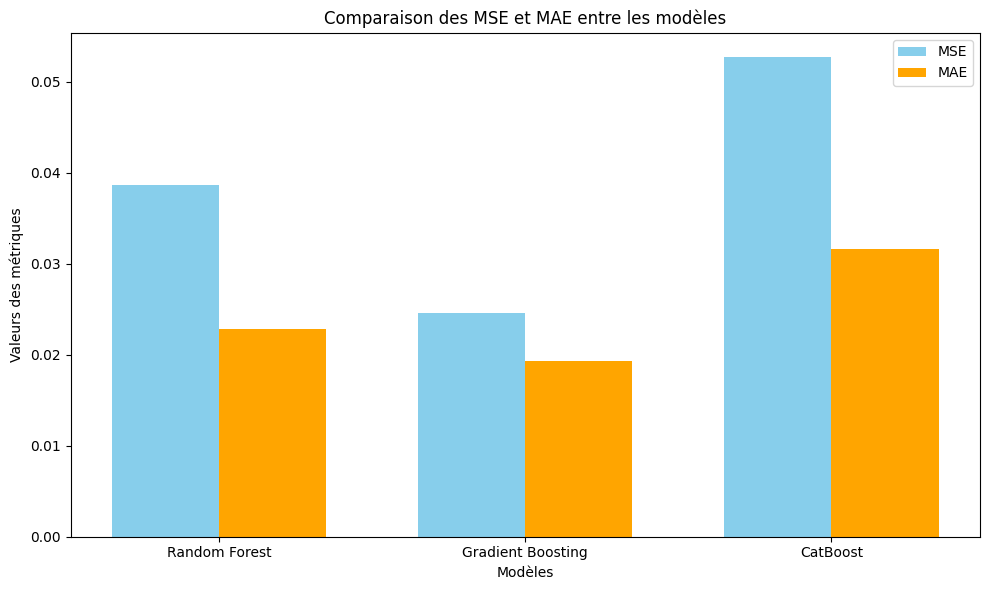

In [156]:
# Valeurs des métriques (à remplacer par vos propres résultats)
models = ["Random Forest", "Gradient Boosting", "CatBoost"]


# Configuration de la largeur des barres
bar_width = 0.35
x = np.arange(len(models))

# Création du diagramme à barres
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, mse_values, bar_width, label='MSE', color='skyblue')
plt.bar(x + bar_width/2, mae_values, bar_width, label='MAE', color='orange')

# Ajout des étiquettes et de la légende
plt.xlabel("Modèles")
plt.ylabel("Valeurs des métriques")
plt.title("Comparaison des MSE et MAE entre les modèles")
plt.xticks(x, models)
plt.legend()

# Affichage
plt.tight_layout()
plt.show()